In [64]:
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from datetime import datetime
import obspy
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from obspy.geodetics import locations2degrees, degrees2kilometers
from tqdm import tqdm

In [2]:
# Read Morton's catalog
events_morton = pd.read_csv('../ds01.csv')

In [3]:
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)

In [4]:
# Get the events in the Morton catalog that occurred on 10/14/2012
t1 = pd.Timestamp('2012-10-14 00:00:00.000000+0000', tz='UTC')
t2 = pd.Timestamp('2012-10-14 23:59:59.999999+0000', tz='UTC')

events_morton_2021014= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

In [5]:
events_morton_2021014

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
671,2.0,2.012101e+13,2012.0,10.0,14.0,2.0,39.0,44.31,40.2517,-124.4555,...,4.7,0.25,0.9,1.6,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-14 02:39:44+00:00
672,2.0,2.012101e+13,2012.0,10.0,14.0,3.0,8.0,1.10,40.7087,-124.1907,...,18.2,0.24,1.0,1.6,NaN,NaN,NaN,Slab,NaN,2012-10-14 03:08:01+00:00
673,2.0,2.012101e+13,2012.0,10.0,14.0,16.0,48.0,33.63,40.3390,-124.6048,...,13.2,0.07,5.4,12.3,NaN,NaN,NaN,Undef,NaN,2012-10-14 16:48:33+00:00


In [6]:
# Load all the pick assignments 
mycatalog = pd.read_csv('../all_pick_assignments.csv')
# Convert the time series in all_pick_assignments to datetime
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)
# Print the first five rows of the catalog
mycatalog.head()

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,283,-0.006772,G19B,P,1.350178e+09,2012-10-14 01:24:03.676530+00:00
1,1,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,843,0.125995,G27B,P,1.350178e+09,2012-10-14 01:24:03.676530+00:00
2,2,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,1053,-0.261009,M12B,P,1.350178e+09,2012-10-14 01:24:03.676530+00:00
3,3,0,2012-10-14 01:24:03.676530+00:00,-99.823478,8.014299,24.609375,4,41.815873,-125.951392,24.609375,0,1938,0.141786,M12B,S,1.350178e+09,2012-10-14 01:24:03.676530+00:00
4,4,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375,1,12,0.377781,FS09B,P,1.350182e+09,2012-10-14 02:39:44.924554+00:00


In [7]:
# Get the picks in my catalog that occurred on 10/14/2012 and match with the three events in Morton's catalog
t1 = events_morton_2021014.iloc[0]['datetime']
event_morton_2021014_023944 = mycatalog.loc[(mycatalog['datetime'] > t1 - pd.Timedelta(5,'minutes')) & (mycatalog['datetime'] < t1 +pd.Timedelta(5,'minutes')) ]

t2 = events_morton_2021014.iloc[1]['datetime']
event_morton_2021014_030801 = mycatalog.loc[(mycatalog['datetime'] > t2 - pd.Timedelta(5,'minutes')) & (mycatalog['datetime'] < t2 +pd.Timedelta(5,'minutes')) ]

t3 = events_morton_2021014.iloc[2]['datetime']
event_morton_2021014_164833 = mycatalog.loc[(mycatalog['datetime'] > t3 - pd.Timedelta(5,'minutes')) & (mycatalog['datetime'] < t3 +pd.Timedelta(5,'minutes')) ]

In [8]:
# Print the events in my catalog that match with the event in Morton's catalog
event_morton_2021014_023944

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
4,4,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375,1,12,0.377781,FS09B,P,1.350182e+09,2012-10-14 02:39:44.924554+00:00
5,5,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375,1,1455,-0.171493,FS09B,S,1.350182e+09,2012-10-14 02:39:44.924554+00:00
6,6,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375,1,190,-0.436940,G10B,P,1.350182e+09,2012-10-14 02:39:44.924554+00:00
7,7,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375,1,1597,0.220285,G10B,S,1.350182e+09,2012-10-14 02:39:44.924554+00:00
8,8,1,2012-10-14 02:39:44.924554+00:00,26.269336,-128.412984,40.234375,5,40.593306,-124.439672,40.234375,1,286,0.010367,G19B,P,1.350182e+09,2012-10-14 02:39:44.924554+00:00


In [9]:
# Print the events in my catalog that match with the event in Morton's catalog
event_morton_2021014_030801

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
9,9,2,2012-10-14 03:08:04.522444+00:00,12.259024,-107.072404,49.609375,7,40.785806,-124.604763,49.609375,2,1456,0.293201,FS09B,S,1.350184e+09,2012-10-14 03:08:04.522444+00:00
10,10,2,2012-10-14 03:08:04.522444+00:00,12.259024,-107.072404,49.609375,7,40.785806,-124.604763,49.609375,2,192,-1.275212,G10B,P,1.350184e+09,2012-10-14 03:08:04.522444+00:00
11,11,2,2012-10-14 03:08:04.522444+00:00,12.259024,-107.072404,49.609375,7,40.785806,-124.604763,49.609375,2,1599,0.826728,G10B,S,1.350184e+09,2012-10-14 03:08:04.522444+00:00
12,12,2,2012-10-14 03:08:04.522444+00:00,12.259024,-107.072404,49.609375,7,40.785806,-124.604763,49.609375,2,288,-0.841498,G19B,P,1.350184e+09,2012-10-14 03:08:04.522444+00:00
13,13,2,2012-10-14 03:08:04.522444+00:00,12.259024,-107.072404,49.609375,7,40.785806,-124.604763,49.609375,2,1630,0.238312,G19B,S,1.350184e+09,2012-10-14 03:08:04.522444+00:00
14,14,2,2012-10-14 03:08:04.522444+00:00,12.259024,-107.072404,49.609375,7,40.785806,-124.604763,49.609375,2,1256,0.128741,M14B,P,1.350184e+09,2012-10-14 03:08:04.522444+00:00
15,15,2,2012-10-14 03:08:04.522444+00:00,12.259024,-107.072404,49.609375,7,40.785806,-124.604763,49.609375,2,2002,0.629728,M14B,S,1.350184e+09,2012-10-14 03:08:04.522444+00:00


In [10]:
# Print the events in my catalog that match with the event in Morton's catalog
event_morton_2021014_164833

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
42,42,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,137,-0.463175,FS09B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
43,43,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1556,-0.702513,FS09B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00
44,44,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,238,0.194385,G10B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
45,45,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1617,-0.254243,G10B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00
46,46,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,324,0.735714,G19B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
47,47,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1657,0.715669,G19B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00
48,48,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,659,0.516474,G25B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
49,49,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1816,-0.353227,G25B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00
50,50,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,904,-0.277795,G27B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
51,51,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1904,-0.840728,G27B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00


In [11]:
client = WaveformClient()
client2 = Client("IRIS")

In [12]:
# Get the list of station
station_list = ['FS09B',
 'FS13B',
 'FS16B',
 'FS17B',
 'FS20B',
 'G10B',
 'G17B',
 'G19B',
 'G25B',
 'G26B',
 'G27B',
 'J09B',
 'J25B',
 'J33B',
 'M09B',
 'M12B',
 'M14B']

In [73]:
mycatalog[mycatalog['idx'] == 7]

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
42,42,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,137,-0.463175,FS09B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
43,43,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1556,-0.702513,FS09B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00
44,44,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,238,0.194385,G10B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
45,45,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1617,-0.254243,G10B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00
46,46,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,324,0.735714,G19B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
47,47,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1657,0.715669,G19B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00
48,48,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,659,0.516474,G25B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
49,49,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1816,-0.353227,G25B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00
50,50,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,904,-0.277795,G27B,P,1.350234e+09,2012-10-14 16:53:05.638758+00:00
51,51,7,2012-10-14 16:53:05.638758+00:00,-60.127592,-121.553512,37.890625,14,40.653305,-125.46094,37.890625,7,1904,-0.840728,G27B,S,1.350234e+09,2012-10-14 16:53:05.638758+00:00


In [77]:
mycatalog['station'].unique()

array(['G19B', 'G27B', 'M12B', 'FS09B', 'G10B', 'M14B', 'G25B', 'J09B'],
      dtype=object)

In [75]:
distances

{'G10B': 8.256025197627078,
 'FS20B': 46.696334920007274,
 'FS13B': 58.073865388928716,
 'FS09B': 60.07071569330717,
 'FS16B': 62.245034109928575,
 'FS17B': 73.71190492412333,
 'G19B': 77.32258146223741,
 'M14B': 82.06883524600721,
 'G17B': 117.05213816035327,
 'G26B': 143.36411406429102,
 'G27B': 147.94751855488474,
 'G25B': 158.67544964052962,
 'M12B': 175.53473742002487,
 'J09B': 284.29230641249535,
 'M09B': 401.25728038572703,
 'J25B': 430.0622902822521,
 'J33B': 500.4603889774671}

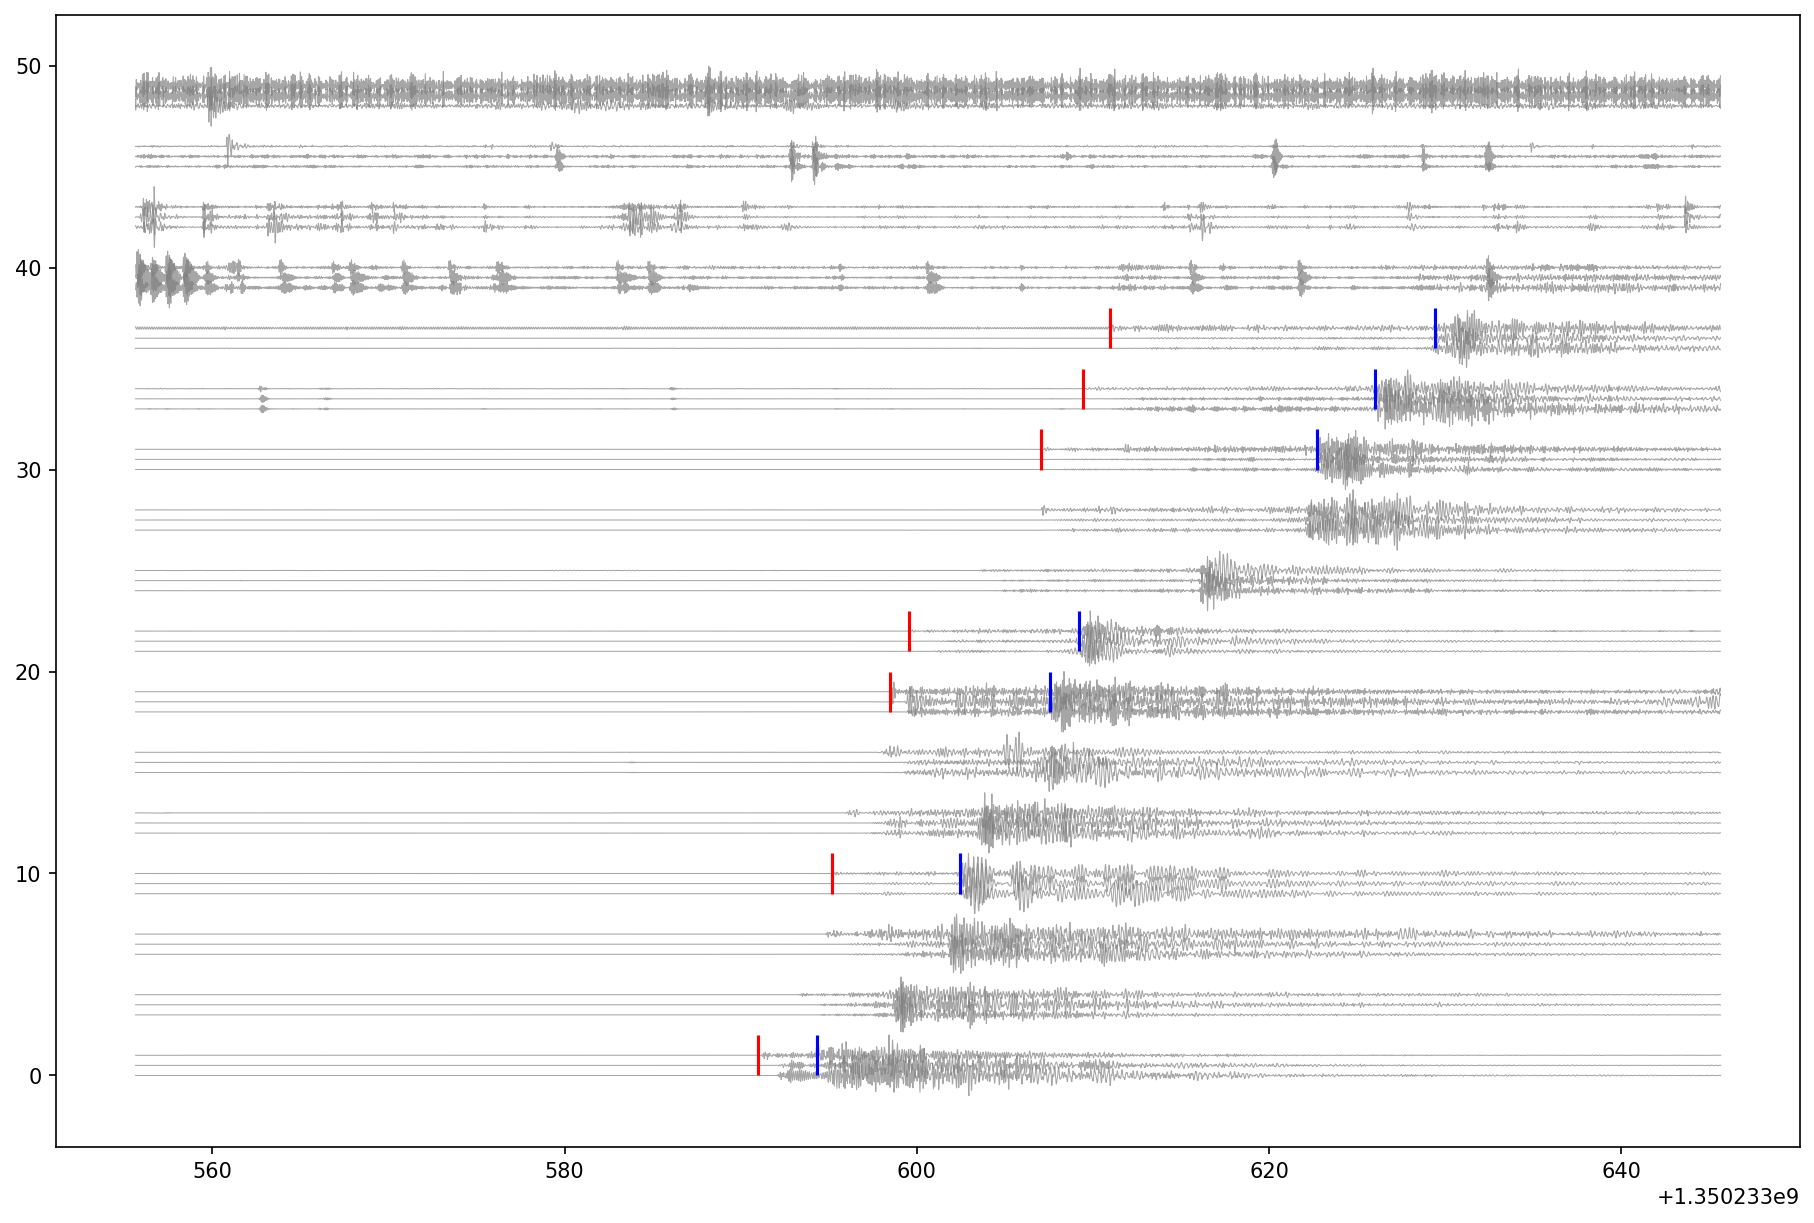

In [74]:
idx = 7
otime = UTCDateTime(mycatalog['datetime'].unique()[idx])

distances = {}
for i, sta in enumerate(station_list):
    sta_inv = client2.get_stations(network = "7D", station = sta, channel = "?H?", 
                     starttime = otime - 1e4, endtime = otime + 1e4)[0][0]
    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = mycatalog['latitude'].unique()[idx]
    olon = mycatalog['longitude'].unique()[idx]

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances[sta] = dist
distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}

plt.figure(figsize=(15,10), dpi=150)
for i, sta in enumerate(distances.keys()):
    st = client.get_waveforms(network="7D", station=sta, channel="?H?", year=2012, month=10, day=14)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 60)

    trim_st = trim_st.normalize()
    offsets1  = np.arange(0,len(trim_st))
    offsets2 = np.arange(0,len(station_list)* (len(trim_st)),len(trim_st))

    for ii in range(len(trim_st)):
        plt.plot(trim_st[ii].times(type='utcdatetime'), trim_st[ii].data+offsets1[ii]*0.5+offsets2[i], 
                 color = 'gray', alpha=0.7, lw=0.5)    
    time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
                 if x['station'] == sta]
    if len(time_pick) > 0:
        for p in time_pick:
            if p[1] == 'P':
                plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
                                 offsets1[ii]*0.5+offsets2[i]+1, color='r')
            else:
                plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
                                 offsets1[ii]*0.5+offsets2[i]+1, color='b')